<a href="https://colab.research.google.com/github/ft-Azad/Language-Modeling/blob/main/LanguageModel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#  Import Libs

In [1]:
!pip install -q torchmetrics
!pip install -q torchdata==0.6.1
!pip install 'portalocker>=2.0.0'
!pip install torchtext==0.15.1

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 868.8/868.8 kB 13.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21.3 MB 50.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.6/4.6 MB 12.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 619.9/619.9 MB 1.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.0/21.0 MB 72.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 849.3/849.3 kB 70.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.8/11.8 MB 102.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 557.1/557.1 MB 2.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.1/317.1 MB 2.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 168.4/168.4 MB 7.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.6/54.6 MB 11.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 102.6/102.6 MB 8.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━

In [63]:
import numpy as np
import matplotlib.pyplot as plt

import torchtext
from torchtext.datasets import WikiText2
from torchdata.datapipes.iter import IterableWrapper, Mapper
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator

import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset, random_split

from torch import optim
from torch.nn import functional as F

import tqdm
import torchmetrics as tm

from collections import Counter

In [3]:
for lib in [np, torch, torchtext, tqdm]:
  print(lib.__name__, '-->', lib.__version__)

numpy --> 1.25.2
torch --> 2.0.0+cu117
torchtext --> 0.15.1+cpu
tqdm --> 4.66.4


# Utils

In [4]:
# !git clone https://github.com/ft-Azad/Language-Modeling

In [5]:
# %cd ..

In [6]:
# %ls

In [7]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [8]:
def num_trainable_params(model):
  nums = sum(p.numel() for p in model.parameters() if p.requires_grad)/1e6
  return nums

#Dataset

## Load Dataset and Build Vocab

- Loading Iterable Data

In [9]:
# train_iter, valid_iter, test_iter = WikiText2('/content/')

In [11]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [12]:
!unzip -q "/content/drive/MyDrive/LanguageModel/Data/wikitext-2-v1.zip" -d '/content/'

In [13]:
with open('/content/wikitext-2/wiki.train.tokens', 'r') as file:
    train_iter = file.read().splitlines()

with open('/content/wikitext-2/wiki.test.tokens', 'r') as file:
    test_iter = file.read().splitlines()

with open('/content/wikitext-2/wiki.valid.tokens', 'r') as file:
    valid_iter = file.read().splitlines()

train_iter = IterableWrapper(train_iter)
test_iter = IterableWrapper(test_iter)
valid_iter = IterableWrapper(valid_iter)

In [14]:
train_iter_ = iter(train_iter)
train_iter_

<generator object IterableWrapperIterDataPipe.__iter__ at 0x79d8503d23b0>

In [15]:
next(train_iter_)

' '

- Build Vocabulary

In [16]:
txt = ['@Azad hi Azad! 1 n2 3 #45', 'how are are you?']
tokenizer = get_tokenizer('basic_english')
[tokenizer(line) for line in txt]
list(map(tokenizer, txt))

[['@azad', 'hi', 'azad', '!', '1', 'n2', '3', '#45'],
 ['how', 'are', 'are', 'you', '?']]

In [17]:
vocab = build_vocab_from_iterator(map(tokenizer, txt), specials=['<ukn>'], min_freq=1)
vocab.set_default_index(vocab['<ukn>'])
vocab.get_stoi()

{'n2': 11,
 'how': 10,
 'you': 12,
 'hi': 9,
 'azad': 8,
 '@azad': 7,
 '?': 6,
 '3': 5,
 '1': 4,
 '#45': 3,
 '!': 2,
 'are': 1,
 '<ukn>': 0}

In [18]:
vocab(['hi', 'azad', '<ukn>', 'hello', 'Hi'.lower()])

[9, 8, 0, 0, 9]

In [37]:
tokenizer = get_tokenizer('basic_english')
vocab = build_vocab_from_iterator(map(tokenizer, train_iter), specials=['<unk>'])
vocab.set_default_index(vocab['<unk>'])
vocab.append_token("<eos>")

In [38]:
len(vocab)

28783

In [39]:
torch.save(vocab, 'vocab.pt')
torch.save(vocab, '/content/drive/MyDrive/LanguageModel/vocab.pt')

## Dataset Properties (EDA)


In [22]:
total_sentence_count = 0
total_sentence_length = 0

for line in train_iter:
    sentences = line.split('.')

    for sentence in sentences:
        tokens = sentence.strip().split()
        sentence_length = len(tokens)

        if sentence_length > 0:
            total_sentence_count += 1
            total_sentence_length += sentence_length

mean_sentence_length = total_sentence_length / total_sentence_count

print(f'Mean sentence length in Wikitext-2: {mean_sentence_length:.2f}')

Mean sentence length in Wikitext-2: 21.69


In [23]:
freqs = Counter()
for tokens in map(tokenizer, train_iter):
  freqs.update(tokens)

In [24]:
freqs.most_common()[:50]

[('the', 130768),
 (',', 102615),
 ('.', 83397),
 ('of', 57030),
 ('<unk>', 54625),
 ('and', 50735),
 ('in', 45015),
 ('to', 39521),
 ('a', 36523),
 ('=', 29570),
 ('was', 21008),
 ("'", 18484),
 ('@-@', 16906),
 ('on', 15140),
 ('as', 15058),
 ('s', 14936),
 ('that', 14351),
 ('for', 13794),
 ('with', 13012),
 ('by', 12718),
 (')', 12004),
 ('(', 11992),
 ('@', 11786),
 ('is', 11691),
 ('it', 9273),
 ('from', 9229),
 ('at', 9070),
 ('his', 9019),
 ('he', 8706),
 ('were', 7334),
 ('an', 6250),
 ('had', 5707),
 ('which', 5546),
 ('be', 4859),
 ('are', 4714),
 ('this', 4560),
 ('their', 4290),
 ('first', 4242),
 ('but', 4233),
 ('not', 4006),
 ('–', 3934),
 ('one', 3910),
 ('they', 3894),
 ('its', 3877),
 ('also', 3842),
 ('after', 3749),
 ('her', 3670),
 ('or', 3655),
 ('two', 3565),
 ('have', 3470)]

In [25]:
freqs.most_common()[::-1][:50]

[('gallinae', 3),
 ('intergrades', 3),
 ('northeasterly', 3),
 ('tuscola', 3),
 ('roundabouts', 3),
 ('zoromski', 3),
 ('forrester', 3),
 ('kreutzer', 3),
 ('prefaced', 3),
 ('philipp', 3),
 ('chants', 3),
 ('sonatine', 3),
 ('mineurs', 3),
 ('étude', 3),
 ('caprices', 3),
 ('lewenthal', 3),
 ('spruces', 3),
 ('secretion', 3),
 ('tomentum', 3),
 ('yellowwoods', 3),
 ('echinodontium', 3),
 ('urocerus', 3),
 ('γ', 3),
 ('2γ', 3),
 ('2e', 3),
 ('tauri', 3),
 ('supergiants', 3),
 ('flamsteed', 3),
 ('novae', 3),
 ('sn', 3),
 ('hipparchus', 3),
 ('radiative', 3),
 ('dope', 3),
 ('shaggy', 3),
 ('utsler', 3),
 ('psychopathic', 3),
 ('brunette', 3),
 ('aar', 3),
 ('gigalitres', 3),
 ('jodidio', 3),
 ('barco', 3),
 ('puckering', 3),
 ('saic', 3),
 ('krueck', 3),
 ('squirtle', 3),
 ('schauenburg', 3),
 ('mechtshausen', 3),
 ('drunkards', 3),
 ('schopenhauer', 3),
 ('kremplsetzer', 3)]

## Dataset Prepreation

- Creat Target Array

In [43]:
def data_process(raw_text_iter, seq_len):
  data = torch.cat([torch.LongTensor(vocab(tokenizer(line)) + vocab(["<eos>"])) for line in raw_text_iter])

  M = len(data) // seq_len

  r = len(data) % seq_len
  data = torch.cat((data, torch.LongTensor([0]))) if r==0 else data

  inputs = data[:M*seq_len]
  inputs = inputs.reshape(-1, seq_len)

  targets = data[1:M*seq_len+1]
  targets = targets.reshape(-1, seq_len)

  return inputs, targets

In [44]:
inputs, targets = data_process(train_iter, seq_len=65)
inputs.shape, targets.shape

(torch.Size([32103, 65]), torch.Size([32103, 65]))

In [45]:
seq_len = 35

X_train, y_train = data_process(train_iter, seq_len)
X_valid, y_valid = data_process(valid_iter, seq_len)
X_test, y_test = data_process(test_iter, seq_len)

X_train.shape, y_train.shape, X_valid.shape, y_valid.shape, X_test.shape, y_test.shape

(torch.Size([59620, 35]),
 torch.Size([59620, 35]),
 torch.Size([6233, 35]),
 torch.Size([6233, 35]),
 torch.Size([7034, 35]),
 torch.Size([7034, 35]))

- Custom Dataset Class Definition
  - (Map custom dataset used instead of iterable custom dataset because of small dataset length)

In [46]:
class LanguageModelDataset(Dataset):

  def __init__(self, inputs, targets):
    self.inputs = inputs
    self.targets = targets

  def __len__(self):
    return self.inputs.shape[0]

  def __getitem__(self, idx):
    return self.inputs[idx], self.targets[idx]

In [47]:
train_set = LanguageModelDataset(X_train, y_train)
valid_set = LanguageModelDataset(X_valid, y_valid)
test_set = LanguageModelDataset(X_test, y_test)

In [48]:
train_set[0]

(tensor([28782,     9,  3849,  3869,   881,     9, 28782, 28782, 20000,    83,
          3849,    88,     0,  3869,    21,   780, 28780,     2,  6182,     3,
          3849,     4,     1,  5023,    88,    20,     2,  1837,  1018,     7,
            14,  3849,  3869,   881,   629]),
 tensor([    9,  3849,  3869,   881,     9, 28782, 28782, 20000,    83,  3849,
            88,     0,  3869,    21,   780, 28780,     2,  6182,     3,  3849,
             4,     1,  5023,    88,    20,     2,  1837,  1018,     7,    14,
          3849,  3869,   881,   629,   976]))

- Data Loader

In [49]:
batch_size = 20

train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_set, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False)

In [50]:
x_batch, y_batch = next(iter(train_loader))
x_batch.shape, y_batch.shape

(torch.Size([20, 35]), torch.Size([20, 35]))

# Model

In [51]:
class LanguageModel(nn.Module):

  def __init__(self, vocab_size, embedding_dim, hidden_dim, num_layers,
                dropout_embd=0.5, dropout_rnn=0.5):
    super().__init__()
    self.num_layers = num_layers
    self.hidden_dim = hidden_dim
    self.embedding_dim = embedding_dim

    self.embedding = nn.Embedding(vocab_size, embedding_dim)
    self.embedding.weight.data.uniform_(-0.1, 0.1)
    self.dropout = nn.Dropout(p=dropout_embd)

    self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers=num_layers,
                        dropout=dropout_rnn, batch_first=True)

    self.fc = nn.Linear(hidden_dim, vocab_size)

  def forward(self, src):
    embedding = self.dropout(self.embedding(src))
    output, hidden = self.lstm(embedding)
    prediction = self.fc(output)
    return prediction

In [52]:
model = LanguageModel(vocab_size=len(vocab),
                      embedding_dim=300,
                      hidden_dim=512,
                      num_layers=2,
                      dropout_embd=0.65,
                      dropout_rnn=0.5)
model

LanguageModel(
  (embedding): Embedding(28783, 300)
  (dropout): Dropout(p=0.65, inplace=False)
  (lstm): LSTM(300, 512, num_layers=2, batch_first=True, dropout=0.5)
  (fc): Linear(in_features=512, out_features=28783, bias=True)
)

In [53]:
len(vocab), x_batch.shape, model(x_batch).shape

(28783, torch.Size([20, 35]), torch.Size([20, 35, 28783]))

In [54]:
num_trainable_params(model.embedding), num_trainable_params(model.lstm), num_trainable_params(model.fc)

(8.6349, 3.76832, 14.765679)

# Configuration

In [55]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [56]:
vocab_size = len(vocab)
embedding_dim = 300
hidden_dim = 512
num_layers = 2
dropout_embd = 0.5
dropout_rnn = 0.2

model = LanguageModel(vocab_size, embedding_dim,
                      hidden_dim, num_layers,
                      dropout_embd, dropout_rnn).to(device)

In [57]:
optimizer = optim.SGD(model.parameters(), lr=0.5, weight_decay=0, momentum=0.9, nesterov=True)

loss_fn = nn.CrossEntropyLoss()

metric = tm.text.Perplexity().to(device)

In [58]:
clip = 0.25

# Train

## Train and Evaluate Functions

In [59]:
# Train Functions
def train_one_epoch(model, train_loader, loss_fn, optimizer, metric, epoch=None):
  model.train()
  loss_train = AverageMeter()
  metric.reset()

  with tqdm.tqdm(train_loader, unit='batch') as tepoch:
    for inputs, targets in tepoch:
      if epoch:
        tepoch.set_description(f'Epoch {epoch}')

      inputs = inputs.to(device)
      targets = targets.to(device)

      outputs = model(inputs)

      loss = loss_fn(outputs.reshape(-1, outputs.shape[-1]), targets.flatten())

      loss.backward()

      nn.utils.clip_grad.clip_grad_norm_(model.parameters(), max_norm=clip)

      optimizer.step()
      optimizer.zero_grad()

      loss_train.update(loss.item(), n=len(targets))
      metric.update(outputs, targets)

      tepoch.set_postfix(loss=loss_train.avg, metric=metric.compute().item())

  return model, loss_train.avg, metric.compute().item()

In [60]:
# Evaluate Function
def evaluate(model, test_loader, loss_fn, metric):
  model.eval()
  loss_eval = AverageMeter()
  metric.reset()

  with torch.inference_mode():
    for inputs, targets in test_loader:
      inputs = inputs.to(device)
      targets = targets.to(device)

      outputs = model(inputs)

      loss = loss_fn(outputs.reshape(-1, outputs.shape[-1]), targets.flatten())
      loss_eval.update(loss.item(), n=len(targets))

      metric(outputs, targets)

  return loss_eval.avg, metric.compute().item()

## Train Process and Tunning

### Finding Hyper-parameters

- Calculating the loss for untrained model using a few batches

In [62]:
for iter_num in range(5):
  model = LanguageModel(len(vocab), embedding_dim=300,
                        hidden_dim=512, num_layers=2,
                        dropout_embd=0.5, dropout_rnn=0.2).to(device)

  inputs, targets = next(iter(train_loader))
  inputs = inputs.to(device)
  targets = targets.to(device)

  with torch.no_grad():
    outputs = model(inputs)
    loss = loss_fn(outputs.reshape(-1, outputs.shape[-1]), targets.flatten())

  print(loss)

tensor(10.2716, device='cuda:0')
tensor(10.2680, device='cuda:0')
tensor(10.2713, device='cuda:0')
tensor(10.2687, device='cuda:0')
tensor(10.2679, device='cuda:0')


- Train and try to overfit the model on a small subset of the dataset.

In [64]:
model = LanguageModel(len(vocab), embedding_dim=300,
                      hidden_dim=512, num_layers=2,
                      dropout_embd=0.5, dropout_rnn=0.2).to(device)

optimizer = torch.optim.SGD(model.parameters(), lr=0.9, momentum=0.9)

In [65]:
mini_train_size = 1000
_, mini_train_dataset = random_split(train_set, (len(train_set)-mini_train_size, mini_train_size))
mini_train_loader = DataLoader(mini_train_dataset, 20)

In [66]:
num_epochs = 100
for epoch in range(num_epochs):
  model, _, _ = train_one_epoch(model, mini_train_loader, loss_fn, optimizer, metric, epoch)

Epoch 99: 100%|██████████| 50/50 [00:01<00:00, 25.68batch/s, loss=0.247, metric=1.28]


-  Train the model for a limited number of epochs, experimenting with various learning rates to find best value

In [69]:
num_epochs = 1

for lr in [8, 5, 2, 0.7, 0.5, 0.2]:
  print(f'LR={lr}')

  model = LanguageModel(len(vocab), embedding_dim=300,
                      hidden_dim=512, num_layers=2,
                      dropout_embd=0.5, dropout_rnn=0.2).to(device)
  # model = torch.load('/content/model-ppl_147.pt')

  # optimizer = optim.SGD(model.parameters(), lr=lr, weight_decay=0, momentum=0.9)
  optimizer = optim.SGD(model.parameters(), lr=lr, weight_decay=1e-6, momentum=0.9)

  for epoch in range(num_epochs):
    model, _, _ = train_one_epoch(model, train_loader, loss_fn, optimizer, metric, epoch)

  print()

LR=8


100%|██████████| 2981/2981 [01:56<00:00, 25.67batch/s, loss=5.75, metric=314]



LR=5


100%|██████████| 2981/2981 [01:59<00:00, 24.88batch/s, loss=5.75, metric=315]



LR=2


 88%|████████▊ | 2614/2981 [01:42<00:14, 25.45batch/s, loss=5.95, metric=382]


KeyboardInterrupt: 

- Creat a small grid search to find exact value of lr and weight decay

In [70]:
num_epochs = 2

for lr in [8.]:
  for wd in [1e-6, 1e-5, 1e-4]:
    print(f'LR={lr}, WD={wd}')

    model = LanguageModel(len(vocab), embedding_dim=300,
                      hidden_dim=512, num_layers=2,
                      dropout_embd=0.5, dropout_rnn=0.2).to(device)

    optimizer = optim.SGD(model.parameters(), lr=lr, weight_decay=wd, momentum=0.9)

    for epoch in range(num_epochs):
      model, _, _ = train_one_epoch(model, train_loader, loss_fn, optimizer, metric, epoch)

    print()

LR=8.0, WD=1e-06


Epoch 1: 100%|██████████| 2981/2981 [02:00<00:00, 24.67batch/s, loss=5.34, metric=209]



LR=8.0, WD=1e-05


Epoch 1: 100%|██████████| 2981/2981 [01:59<00:00, 24.98batch/s, loss=5.48, metric=239]



LR=8.0, WD=0.0001


Epoch 1: 100%|██████████| 2981/2981 [01:58<00:00, 25.07batch/s, loss=6.27, metric=528]

- Train model for more epochs using the best hyperparameters

In [71]:
model = LanguageModel(len(vocab), embedding_dim=300,
                      hidden_dim=512, num_layers=2,
                      dropout_embd=0.5, dropout_rnn=0.5).to(device)

In [72]:
lr = 8
wd = 1e-6
optimizer = optim.SGD(model.parameters(), lr=lr, weight_decay=wd, momentum=0.9)

In [73]:
loss_train_hist = []
loss_valid_hist = []

metric_train_hist = []
metric_valid_hist = []

best_loss_valid = torch.inf
epoch_counter = 0
best_loss_epoch = None

In [74]:
num_epochs = 30

for epoch in range(1, num_epochs+1):
  # Train
  model, loss_train, metric_train = train_one_epoch(model,
                                                    train_loader,
                                                    loss_fn,
                                                    optimizer,
                                                    metric,
                                                    epoch)
  # Validation
  loss_valid, metric_valid = evaluate(model,
                                      valid_loader,
                                      loss_fn,
                                      metric)

  loss_train_hist.append(loss_train)
  loss_valid_hist.append(loss_valid)

  metric_train_hist.append(metric_train)
  metric_valid_hist.append(metric_valid)

  if loss_valid < best_loss_valid:
    torch.save(model, f'modelpt')
    best_loss_valid = loss_valid
    best_loss_epoch = epoch
    print('Model Saved!')

  print(f'Valid: Loss = {loss_valid:.4}, Metric = {metric_valid:.4}')
  print()

  epoch_counter += 1

Epoch 1: 100%|██████████| 2981/2981 [01:59<00:00, 24.99batch/s, loss=5.84, metric=345]


Model Saved!
Valid: Loss = 5.394, Metric = 220.1



Epoch 2: 100%|██████████| 2981/2981 [01:59<00:00, 24.92batch/s, loss=5.51, metric=248]


Model Saved!
Valid: Loss = 5.297, Metric = 199.7



Epoch 3: 100%|██████████| 2981/2981 [01:59<00:00, 24.99batch/s, loss=5.39, metric=220]


Model Saved!
Valid: Loss = 5.253, Metric = 191.2



Epoch 4: 100%|██████████| 2981/2981 [01:59<00:00, 25.05batch/s, loss=5.3, metric=201]


Model Saved!
Valid: Loss = 5.218, Metric = 184.5



Epoch 5: 100%|██████████| 2981/2981 [02:00<00:00, 24.83batch/s, loss=5.23, metric=188]


Valid: Loss = 5.222, Metric = 185.3



Epoch 6: 100%|██████████| 2981/2981 [02:00<00:00, 24.73batch/s, loss=5.18, metric=177]


Model Saved!
Valid: Loss = 5.162, Metric = 174.4



Epoch 7: 100%|██████████| 2981/2981 [02:00<00:00, 24.83batch/s, loss=5.13, metric=169]


Model Saved!
Valid: Loss = 5.159, Metric = 174.0



Epoch 8: 100%|██████████| 2981/2981 [01:59<00:00, 24.88batch/s, loss=5.09, metric=162]


Valid: Loss = 5.164, Metric = 174.9



Epoch 9: 100%|██████████| 2981/2981 [01:59<00:00, 24.96batch/s, loss=5.05, metric=157]


Valid: Loss = 5.165, Metric = 175.1



Epoch 10: 100%|██████████| 2981/2981 [01:59<00:00, 25.04batch/s, loss=5.02, metric=152]


Valid: Loss = 5.198, Metric = 180.9



Epoch 11: 100%|██████████| 2981/2981 [01:59<00:00, 25.03batch/s, loss=5, metric=148]


Model Saved!
Valid: Loss = 5.154, Metric = 173.1



Epoch 12:  77%|███████▋  | 2288/2981 [01:31<00:27, 24.99batch/s, loss=4.95, metric=141]


KeyboardInterrupt: 

### Main Train Loop

In [75]:
model = torch.load('/content/model-174.pt')
torch.save(model, f'model.pt')
shutil.copyfile("model-174.pt", "/content/drive/MyDrive/LanguageModel/model-174.pt")

In [83]:
import shutil
shutil.copyfile("model-145.pt", "/content/drive/MyDrive/LanguageModel/model-145.pt")

'/content/drive/MyDrive/LanguageModel/model-145.pt'

In [76]:
lr = 3
wd = 1e-6
optimizer = optim.SGD(model.parameters(), lr=lr, weight_decay=wd, momentum=0.9)

In [ ]:
loss_train_hist = []
loss_valid_hist = []

metric_train_hist = []
metric_valid_hist = []

best_loss_valid = torch.inf
epoch_counter = 0

In [80]:
num_epochs = 20

for epoch in range(num_epochs):
  # Train
  model, loss_train, metric_train = train_one_epoch(model,
                                                    train_loader,
                                                    loss_fn,
                                                    optimizer,
                                                    metric,
                                                    epoch)
  # Validation
  loss_valid, metric_valid = evaluate(model,
                                      valid_loader,
                                      loss_fn,
                                      metric)


  loss_train_hist.append(loss_train)
  loss_valid_hist.append(loss_valid)

  metric_train_hist.append(metric_train)
  metric_valid_hist.append(metric_valid)

  if loss_valid < best_loss_valid:
    torch.save(model, f'model.pt')
    best_loss_valid = loss_valid
    best_loss_epoch = epoch
    print('Model Saved!')

  print(f'Valid: Loss = {loss_valid:.4}, Metric = {metric_valid:.4}')
  print()

  epoch_counter += 1

100%|██████████| 2981/2981 [01:56<00:00, 25.60batch/s, loss=4.66, metric=106]


Model Saved!
Valid: Loss = 5.004, Metric = 149.1



Epoch 1: 100%|██████████| 2981/2981 [02:00<00:00, 24.75batch/s, loss=4.59, metric=98.4]


Model Saved!
Valid: Loss = 4.989, Metric = 146.8



Epoch 2: 100%|██████████| 2981/2981 [02:00<00:00, 24.74batch/s, loss=4.53, metric=93.1]


Model Saved!
Valid: Loss = 4.978, Metric = 145.2



Epoch 3: 100%|██████████| 2981/2981 [02:00<00:00, 24.75batch/s, loss=4.49, metric=88.8]


Valid: Loss = 4.979, Metric = 145.4



Epoch 4: 100%|██████████| 2981/2981 [01:59<00:00, 24.91batch/s, loss=4.44, metric=85.2]


Valid: Loss = 4.979, Metric = 145.4



Epoch 5: 100%|██████████| 2981/2981 [02:00<00:00, 24.82batch/s, loss=4.41, metric=82]


Model Saved!
Valid: Loss = 4.977, Metric = 145.1



Epoch 6: 100%|██████████| 2981/2981 [02:01<00:00, 24.62batch/s, loss=4.37, metric=79.1]


Valid: Loss = 4.989, Metric = 146.8



Epoch 7:   3%|▎         | 87/2981 [00:03<01:57, 24.60batch/s, loss=4.22, metric=67.9]


KeyboardInterrupt: 

### Plot Learning Curve

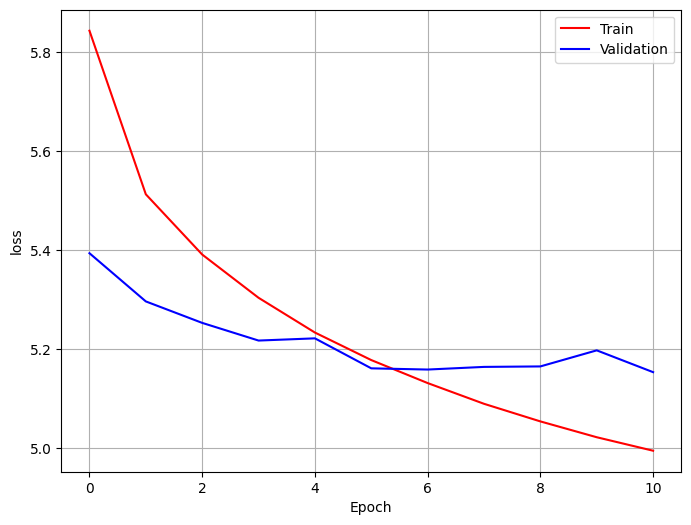

In [77]:
plt.figure(figsize=(8, 6))

plt.plot(range(epoch_counter), loss_train_hist, 'r-', label='Train')
plt.plot(range(epoch_counter), loss_valid_hist, 'b-', label='Validation')

plt.xlabel('Epoch')
plt.ylabel('loss')
plt.grid(True)
plt.legend()